In [2]:
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps


In [3]:
import torch
import torchaudio
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from PIL import Image
from torchvision.transforms.functional import to_pil_image
import random
#from plot_audio import plot_specgram, plot_waveform
#os.getcwd()

/Users/jansta/miniconda3/envs/pytorch2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/jansta/miniconda3/envs/pytorch2/lib/python3.10/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [4]:
dict_mats = np.load('/Users/jansta/learn/acoustics/dict_mats_dB.npy', allow_pickle=True).item()


In [5]:
len(dict_mats['A']['can_opening'][3])

all_labels = dict_mats['A'].keys()
print(all_labels)

dict_keys(['dog', 'chirping_birds', 'vacuum_cleaner', 'thunderstorm', 'door_wood_knock', 'can_opening', 'crow', 'clapping', 'fireworks', 'chainsaw', 'airplane', 'mouse_click', 'pouring_water', 'train', 'sheep', 'water_drops', 'church_bells', 'clock_alarm', 'keyboard_typing', 'wind', 'footsteps', 'frog', 'cow', 'brushing_teeth', 'car_horn', 'crackling_fire', 'helicopter', 'drinking_sipping', 'rain', 'insects', 'laughing', 'hen', 'engine', 'breathing', 'crying_baby', 'hand_saw', 'coughing', 'glass_breaking', 'snoring', 'toilet_flush', 'pig', 'washing_machine', 'clock_tick', 'sneezing', 'rooster', 'sea_waves', 'siren', 'cat', 'door_wood_creaks', 'crickets'])


In [6]:
chosen_labels = ['crickets', 'can_opening', 'chirping_birds', 'dog', 'chainsaw'][:4]
encoded_labels = {'crickets': 0, 'can_opening': 1, 'chirping_birds': 2, 'dog': 3, 'chainsaw': 4}

In [7]:
chosen_labels = list(all_labels)[:10]
print(chosen_labels)
encoded_labels = {}
for i, label in enumerate(chosen_labels):
    encoded_labels[label] = i

['dog', 'chirping_birds', 'vacuum_cleaner', 'thunderstorm', 'door_wood_knock', 'can_opening', 'crow', 'clapping', 'fireworks', 'chainsaw']


In [8]:
class AudioDataset(Dataset):
    def __init__(self, dict_mats, chosen_labels, encoded_labels, transform=None):
        self.X = []
        self.y = []
        self.transform = transform
        for key in dict_mats.keys():
            if key in chosen_labels:
                for i in range(len(dict_mats[key])):
                    self.X.append(dict_mats[key][i])
                    self.y.append(encoded_labels[key])
        
        self.X = np.array(self.X)
        self.y = np.array(self.y)
        
    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        sample = self.X[idx]
        label = self.y[idx]
        
        # Add a channel dimension
        sample = np.expand_dims(sample, axis=0)
        
        # Convert to tensor
        sample = torch.FloatTensor(sample)
        label = torch.tensor(label, dtype=torch.long)
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample, label

In [9]:
transform = transforms.Compose(
    [transforms.Resize((64,431)),
    transforms.Grayscale(num_output_channels=1),
    #transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
    ])

In [ ]:
# Create dataset with transform
dataset = AudioDataset(dict_mats['A'], chosen_labels, encoded_labels, transform=transform)

# Split dataset
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create dataloaders
batch_size = 5
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)



In [31]:
# Create dataset with transform
dataset = AudioDataset(dict_mats['A'], chosen_labels, encoded_labels, transform=transform)
datasetB = AudioDataset(dict_mats['B'], chosen_labels, encoded_labels, transform=transform)

In [34]:
datasetB.X

array([[[ -5.11150574,  -5.61593802,  -8.48841836, ..., -22.2070578 ,
         -22.05645822, -20.5608363 ],
        [-11.64870275, -14.95237732, -16.97135691, ..., -31.64120144,
         -33.42970681, -32.65045129],
        [-17.76797178, -21.48675773, -22.40827365, ..., -30.51972695,
         -32.84333482, -37.19590277],
        ...,
        [-50.40031811, -54.97180002, -56.95328441, ..., -54.28884758,
         -55.5739944 , -58.82006982],
        [-50.69502854, -56.08773933, -62.42843671, ..., -66.60079668,
         -67.63763614, -69.20225437],
        [-51.00568316, -56.72996251, -67.76405001, ..., -78.05226721,
         -77.08072522, -72.18844146]],

       [[-22.34739931, -22.44044086, -20.54546249, ..., -22.03511866,
         -22.69450545, -20.74624869],
        [-20.66263964, -10.51089421,  -7.48842354, ..., -14.87856649,
         -12.97031136, -11.58587976],
        [-20.89996737, -12.76132348, -11.53079388, ..., -12.93891719,
         -11.17558555, -11.84063181],
        ...,


In [16]:
# from audio_ds_model import AudioClassifNetXAI   
# ## Create an  instance of the model:
# model = AudioClassifNetXAI(50)
data = np.load('results_and_model_acc_87.4_nclasses_50.npy', allow_pickle=True).item()
data.keys()



dict_keys(['mean_loss', 'acc', 'cm', 'model', 'gradCAM_out'])

In [30]:
grad_data = data['gradCAM_out']
#print(grad_data[0].keys())
print(len(grad_data[0].keys()))
print(len(grad_data[0].values()))
#print(grad_data[1].keys())
print(len(grad_data[1].keys()))
print(len(grad_data[1].values()))

46
46
46
46


Accuracy: 88.33 %


<Axes: >

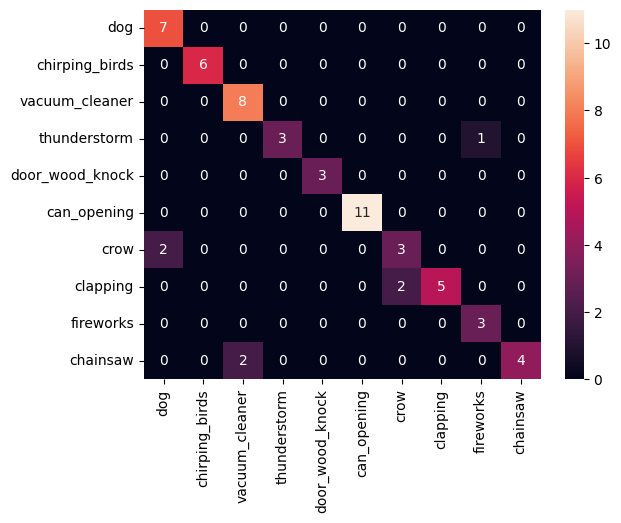

In [26]:

# Accuracy
acc = accuracy_score(y_val, np.argmax(y_val_hat, axis=1))
print(f'Accuracy: {acc*100:.2f} %')
# confusion matrix
cm = confusion_matrix(y_val, np.argmax(y_val_hat, axis=1))
sns.heatmap(cm, annot=True, xticklabels=chosen_labels, yticklabels=chosen_labels)

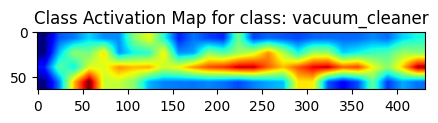

<Figure size 640x480 with 0 Axes>

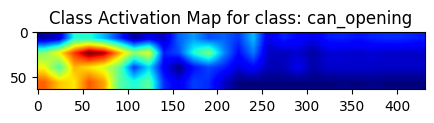

<Figure size 640x480 with 0 Axes>

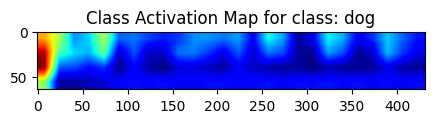

<Figure size 640x480 with 0 Axes>

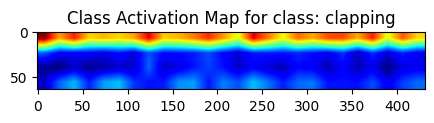

<Figure size 640x480 with 0 Axes>

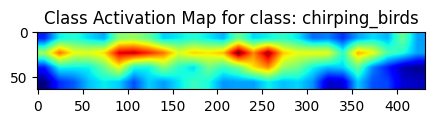

<Figure size 640x480 with 0 Axes>

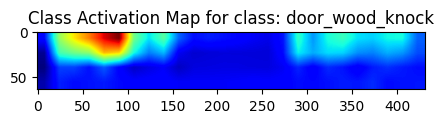

<Figure size 640x480 with 0 Axes>

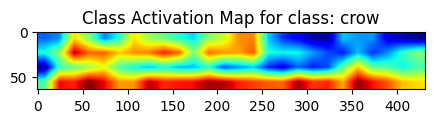

<Figure size 640x480 with 0 Axes>

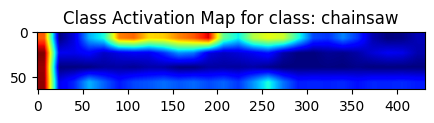

<Figure size 640x480 with 0 Axes>

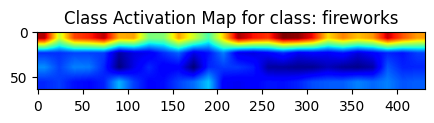

<Figure size 640x480 with 0 Axes>

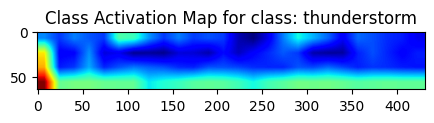

<Figure size 640x480 with 0 Axes>

In [ ]:
for key in class_cams.keys():
    plt.figure(figsize=(5, 10))
    plt.imshow(class_cams[key][0,0,:,:], cmap='jet')
    plt.title(f"Class Activation Map for class: {key}")
    #plt.colorbar()
    plt.show()
    plt.savefig(f'cam_{key}.png')

# if save_output:
#     np.save('class_cams.npy', class_cams)

    # for key in class_cams.keys():
    #     plt.figure(figsize=(5, 10))
    #     plt.imshow(class_cams[key:[0,0,:,:], cmap='jet')
    #     plt.title(f"Class Activation Map for class: {key}")
    #     #plt.colorbar()
    #     plt.show()
    #     plt.savefig(f'cam_{key}.png')


